# Grad-CAM visualization for the classifier

In [14]:
import h5py


import numpy as np


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from qutip.wigner import qfunc
from qutip import coherent

from tf_explain.core import GradCAM

from qst_nn.models.classifier import Classifier
from qst_nn.data.preprocess import remove_data, remap_labels, normalize
from qst_nn.training.train_classifier import loss, optimizer
from qst_nn.utils import plot_confusion_matrix, plot_three_husimi, cat



import matplotlib.pyplot as plt
from matplotlib import colors

from skimage import color
from skimage import io
import os


import cv2

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = ""
tf.keras.backend.set_floatx('float32')

np.random.seed(42)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# https://scipy-cookbook.readthedocs.io/items/Matplotlib_LaTeX_Examples.html
cutoff = 0.9
fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = {# 'backend': 'ps',
          'axes.labelsize': 8,
          'font.size': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'axes.labelpad': 1,
          'text.usetex': False,
          'figure.figsize': fig_size,}
plt.rcParams.update(params)
figpath = "figures/"

In [16]:
hilbert_size = 32

xgrid = 32
ygrid = 32

xvec = np.linspace(-5, 5, xgrid)
yvec = np.linspace(-5, 5, ygrid)


classifier = Classifier()
classifier.compile(optimizer=optimizer,
                   loss=loss,
                   metrics=['accuracy'])


# Create a callback that saves the model's weights
checkpoint_path = "classifier/"
checkpoint_dir = os.path.dirname(checkpoint_path)
classifier.load_weights(checkpoint_path)

# Classify a noisy cat and look at Grad-CAM images

In [17]:
def add_noise(im, sigma = 0.2):
    im = tf.keras.layers.GaussianNoise(sigma*np.max(im))(im, training=True)
    im = im.numpy()
    return im/np.max(im)

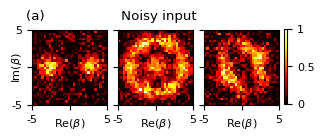

In [18]:
states = [cat(hilbert_size, 2, 0, 0), cat(hilbert_size, 2, 2, 0), cat(hilbert_size, 2, 2, 1)]
data = [qfunc(rho, xvec, yvec) for rho in states]
noisy_images = [normalize(add_noise(img, 0.2)) for img in data]

fig, ax = plot_three_husimi(noisy_images[0], noisy_images[1], noisy_images[2],
                            title="(a)                  Noisy input                       ",
                           cmap="hot")

1/1 [==============================] - 0s 14ms/step


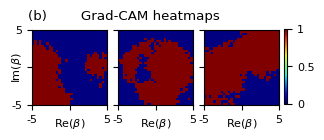

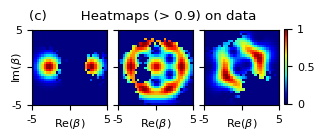

In [19]:
def grad_cam_explanation(model, x, y, x_true, cutoff=0.9,
    heatmap_weight=0.1, image_weight=0.9):
    """
    Args:
        model (tf.model): A TensorFlow model with a predict function
        x (ndarray): Data to explain which is fed to the model (might be noisy)
        y (ndarray): Label
        x_true (ndarray): The true underlying data (without noise). Could be same as x
        cutoff (float, optional): Cutoff for the heatmap.
        heatmap_weight (float, optional): The weight of the heatmap in the overlay
        image_weight (float, optional): The weight of the image in the overlay
    
    Returns:
        grads (ndarray): Array of normalized gradient values
        heatmap_mask (ndarray[bool]): A mask of 0/1 according to the cutoff applied to
                                      the heatmap
        overlayed (ndarray): Array of heatmap overlayed on the image.
    """
    explainer = GradCAM()
    predicted_class = classifier.predict(x.reshape(-1, 32, 32, 1))
    yidx = np.argmax(predicted_class, 1)[0]
    
    grid = explainer.explain((x.reshape(-1, 32, 32, 1),y),
                             model, class_index=np.argmax(predicted_class))

    grads = color.rgb2gray(grid)
    heatmap_img = cv2.applyColorMap(grid, cv2.COLORMAP_JET)
    heatmap_mask = grads > cutoff
    
    
    overlayed = cv2.addWeighted(heatmap_mask.astype(np.float32), heatmap_weight,
                                normalize(x_true.astype(np.float32).reshape(32, 32, 1)),
                                image_weight, 0)
    flat = x_true.astype(np.float32).ravel()
    flat[np.argwhere(~heatmap_mask.ravel())] = 0.

    return grads, heatmap_mask, normalize(flat.reshape((32, 32)))


heatmaps = []
overlay = []

y = [3, 3, 3] # All are cat states

for i in range(len(states)):
    grads, heatmap_mask, overlayed = grad_cam_explanation(classifier, noisy_images[i], y[i], data[i], cutoff=0.8)
    heatmaps.append(heatmap_mask)
    overlay.append(overlayed)

fig, ax = plot_three_husimi(heatmaps[0], heatmaps[1], heatmaps[2], cmap="jet",
                        title="(b)        Grad-CAM heatmaps                 ")
plt.show()

fig, ax = plot_three_husimi(overlay[0], overlay[1], overlay[2], cmap='jet',
                            title="(c)        Heatmaps (> {}) on data        ".format(cutoff))
plt.show()


# Plots in the paper

The requires either the full test data file (~1.8 GB), or generating different,
states, adding noise to them and making predictions. Then you can use
the code below to reproduce Fig 9 from the paper.

Please contact "shahnawaz.ahmed95@gmail.com" for the full data files.

In [20]:
datapath = "data/"

with h5py.File(datapath+"test.h5", 'r') as f:
    xdata_test = f["x"][()]
    ydata_test = f["y"][()]
    
# Data shapes
print("Test x-data shape", xdata_test.shape)
print("Test y-data shape", ydata_test.shape)

xdata_test, ydata_test = remove_data(xdata_test, ydata_test, 3)
ydata_test = remap_labels(ydata_test)


# Any other preprocessing or removal of the data should be done before this step
x_test, y_test = xdata_test.reshape((-1, xgrid, ygrid, 1)), ydata_test.reshape((-1,1))



test_data_generator = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    samplewise_center=False,
    rotation_range=10,
    width_shift_range=.2,
    height_shift_range=.2,
    horizontal_flip=False,
    vertical_flip=False,
    shear_range=0.2,
    zoom_range=0,
)



noisy_images = []
clean_images = []
heatmaps = []
overlay = []
y_label = []
y_pred = []

for idx in [25, 14, 16]:
    x = test_data_generator.apply_transform(x_test[idx], {'theta': 16,
                                                          'tx': .3,
                                                          'ty': .3})
    y = y_test[idx]
    img = x.reshape(1, 32, 32, 1)
    img_noisy = normalize(add_noise(img))
    
    grads, heatmap_mask, overlayed = grad_cam_explanation(classifier, img_noisy, y, img, cutoff=cutoff)
    
    overlay.append(overlayed)
    noisy_images.append(img_noisy.reshape(32, 32))
    clean_images.append(img.reshape(32, 32))
    heatmaps.append(grads)

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = 'data/test.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
fig, ax = plot_three_husimi(noisy_images[0], noisy_images[1], noisy_images[2],
                            title="(a)                  Noisy input                       ",
                           cmap="hot")
plt.show()

In [ ]:
fig, ax = plot_three_husimi(heatmaps[0], heatmaps[1], heatmaps[2], cmap="jet",
                            title="(b)        Grad-CAM heatmaps                 ")
plt.show()

In [ ]:
fig, ax = plot_three_husimi(overlay[0], overlay[1], overlay[2], cmap='hot',
                            title="(c)        Heatmaps (> {}) on data        ".format(cutoff))
plt.show()